# Tutorial 1- Optimal Control and Fishing

(By Zhengwei Wu and Xaq Pitkow)

Please execute the cell below to initialize the notebook environment.


In [1]:
import numpy as np                 # import numpy
import scipy                       # import scipy
import random                      # import basic random number generator functions
from scipy.linalg import inv

import matplotlib.pyplot as plt    # import matplotlib
%matplotlib inline

from IPython import display

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
#plt.style.use('dark_background')

---

## Tutorial objectives

In this tutorial, we will implement a binary control task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is. Based on when and where you catch fish, you keep updating your belief about the fish location, i.e. the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. Now we introduce you to the new concepts of **control, utility, policy**.


---

## Task Description

There are two locations for the fish and you (Left and Right). If you're on the same side as the fish, you'll catch more, with probabilty $q_{\rm high}$ per discrete time step. Otherwise you may still catch fish with probability $q_{\rm low}$. One fish is worth 1 "point".

The fish location is latent. The only information you have about the fish location is when you catch one. Secretly the fish switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$.


You are in control of your location. You may stay on your current side with no cost, or switch to the other side and incur an action cost $c$ (again, in units of fish).

You select controls or actions by following a **policy**. This defines what to do in any situation. Here the situation is specified by your location and your belief about the fish location. For optimal control we assume that this belief is the posterior probability over the current fish location, given all the past measurements. We only need one number for this, since the fish are either on the left or the right. So we write 

$$b_t = p(s^{\rm fish}_t = {\rm Right}\  |\  m_{0:t}, a_{0:t-1})$$

where $m$ are the measurements, and $a$ are the controls or actions (stay or switch).

Here we parameterize the policy by a simple threshold on beliefs. (This happens to be optimal if you pick the right threshold!) When your belief that fish are on the current side falls below a threshold $\theta$, you switch to the other side.


---
### Exercise 1: Binary POMDP
In this excercise, we define the binary POMDP task described above. 

** Suggestions **
* The code has been wrapped into an object. We provide a lazy policy function `def policy_lazy(self, belief, loc)` in which you always stay on one side. 
* You must code a policy based on threshold in `def policy_threshold(self, threshold, belief, loc)`. The policy takes three inputs: your belief that the fish is on the right (a real number between 0 and 1), your location ("Left" or "Right"), and an action threshold. When your belief that you are on the same side as the fish drops below the threshold, you choose to switch, and otherwise stay.
* For convenience, your belief at time *t* is actually a 2-dimensional vector, with the first element being the belief that the fish are on the left, and the second element is the belief the fish are on the right. You will need to return the action for time *t*, which takes the value of "stay" or "switch".

In [5]:
class binaryHMM():
    def __init__(self, params, choose_policy = "threshold"):
        self.params = params
        self.choose_policy = choose_policy
    
    def generateProcess(self):  
        """
        This function generates the dynamics
        """
        
        T, p_stay, rp_high, rp_low, threshold = self.params
        world_state = np.zeros((2, T), int)  # 1: high-rewarding box; 0: low-rewarding box
        loc  = np.zeros(T, int)               # 0: left box, 1: right box
        meas = np.zeros(T, int)               # 0: no food, 1: get food
        act  = np.empty(T, dtype='object')    # "stay", or "switch" 
        belief = np.zeros((2, T), float)     # the probability that a certain box is in high-rewarding state,
                                             # the beliefs on the two boxes sum up to be 1


        rp = np.array([rp_low, rp_high])


        for t in range(T):
            if t == 0:
                world_state[0, t] = 1    # high-rewarding box
                world_state[1, t] = 1 - world_state[0, t]
                loc[t] = 0
                meas[t] = 0
                belief_0 = np.random.random(1)[0]
                belief[:, t] = np.array([belief_0, 1 - belief_0])

                act[t] = self.policy(threshold, belief[:, t], loc[t])

            else:
                world_state[0, t] = self.world_state_telegraph(world_state[0, t-1], p_stay)
                world_state[1, t] = 1 - world_state[0, t]

                if act[t - 1] == "stay":
                    loc[t] = loc[t - 1]
                else:  
                    loc[t] = 1 - loc[t - 1]

                # new measurement
                meas[t] = np.random.binomial(1, rp[world_state[loc[t], t-1]])
                belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t], meas[t], p_stay)
                belief[1, t] = 1 - belief[0, t]

                act[t] = self.policy(threshold, belief[:, t], loc[t])

        return belief, loc, act, meas, world_state


    def world_state_telegraph(self, state_past, p_stay):
        """
        state_past is the state of the left site
        """
        ###############################################################################
        ## Insert your code here to:
        ##        generate the new state for the left site with staying probability p_stay
        ###############################################################################
        
        # state_new = ....
        state_new = (1 - np.random.binomial(1, p_stay)) ^ state_past    # ^ is XOR
        # xp: this should not be an exercise. Already covered HMMs; focus on action.

        return state_new
    
    def policy(self, threshold, belief, loc):
        """
        This function chooses policy. 
        """
        if self.choose_policy == "threshold":
            act = self.policy_threshold(threshold, belief, loc)
        if self.choose_policy == "lazy":
            act = self.policy_lazy(belief, loc)
        
        return act
    
    def policy_threshold(self, threshold, belief, loc):
        """
        This function is the policy based on threshold
        """
        ###############################################################################
        ## Insert code to:
        ## generate actions (Stay or Switch) for current belief and location
        ##
        ## Belief is a 2d vector: first element = Prob( fish on Right | measurements )
        ##                       second element = Prob( fish on Left  | measurements )
        ## Returns Switch if Belief that fish are in your current location < threshold
        ###############################################################################
        ###############################################################################
        # Solution to be removed
        if belief[loc]  <= threshold:
            act = "switch"
        else:
            act = "stay"
        ###############################################################################
        # act = ....

        return act
    
    def policy_lazy(self, belief, loc):
        """
        This function is a policy where stay is also taken
        """
        act = "stay"

        return act
    
    def belief_update(self, belief_past, loc, meas, p_stay):
        """
        using PAST belief on the LEFT box, CURRENT location and measurement to update belief
        """
        rp_mat = np.array([[1 - rp_high, rp_high], [1 - rp_low, rp_low]])
        
        # update belief posterior, p(s[t] | meas(0-t), act(0-t-1))
        belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) * rp_mat[loc, meas]
        belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) * rp_mat[1-loc, meas]

        belief_0 = belief_0 / (belief_0 + belief_1)

        return belief_0   

    
    def plot_dynamics(self, belief, loc, act, meas, world_state):
        "Plot the dynamics of 200 time points"
        T = len(meas)

        showlen = min(T, 200)
        startT = 0

        endT = startT + showlen
        showT = range(startT, endT)
        time_range = np.linspace(0, showlen - 1)

        fig, [ax0, ax1, ax_loc] = plt.subplots(3, 1, figsize=(15, 6))
        
        ax0.plot(world_state[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax0.set_ylabel('Fish state', rotation=360, fontsize=18)
        ax0.yaxis.set_label_coords(-0.1, 0.25)
        ax0.set_xticks([0, showlen, showlen])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        ax0.set_xlim([0, showlen])
        ax0.set_ylim([0, 1.1])
        ax0.set_yticks([0, 1])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax0.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax0.set_yticklabels(labels)

        ax1.plot(belief[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax1.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax1.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
        ax1.yaxis.set_label_coords(-0.1, 0.25)
        ax1.set_xlabel('time', rotation=360, fontsize=18)
        ax1.set_ylabel('Belief on \n left', rotation=360, fontsize=18)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.set_xlim([0, showlen])
        ax1.set_yticks([0, 1])
        ax1.set_ylim([0, 1.1])
        ax1.set_xticks([0, showlen, showlen])
        
        ax2 = ax1.twinx()
        
        ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')  
        labels[0] = 'threshold to switch \n from left to right'
        labels[-1] = 'threshold to switch \n from right to left'
        ax2.set_yticks([threshold, 1 - threshold])
        ax2.set_ylim([0, 1.1])
        ax2.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        ax2.set_yticklabels(labels)
        
        
        act_int = (act == "switch" ).astype(int)
        ax_loc.plot(1 - loc[showT], 'g.-', markersize=12, linewidth=5)
        ax_loc.set_ylabel('Your state', rotation=360, fontsize=18)
        ax_loc.plot((act_int[showT] - .1) * .8, 'v', markersize=10, label = 'action')
        ax_loc.plot(meas[showT] * .5, '*', markersize=5, label = 'reward')
        ax_loc.legend(loc="upper right", fontsize = 12)
        ax_loc.set_xlim([0, showlen])
        ax_loc.set_ylim([0, 1])
        ax_loc.set_xticks([0, showlen, showlen])
        ax_loc.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax_loc.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax_loc.set_yticklabels(labels)

        plt.tight_layout()
        plt.show()
        
    
    def belief_histogram(self, belief, bins = 100):
        plt.hist(belief, bins)
        plt.show()



### Exercise 2: Use the binary HMM module to plot dynamics and belief distribution

In Excercise 1, we have defined a class for the binary HMM tasl. Now in this excercise, we used the module to generate the dynamics. With the generated data, we will see what the dynamic looks like, and how the beliefs are distributed, etc.

** Suggestions **
* With the class defined above, create an object of `binaryHMM` given parameters of the dynamic *params* and a parameter for policy. 
* The parameter for policy can be either *"lazy"* or *"threshold"*. In the following example the policy is the lazy policy. After you compelete the code for the policy based on threshold in Excercise 1, comment the line using the "lazy" policy, and uncomment the line with "threshold" policy".
* We have provided an example of the parameters. You can play with the parameters to see the dynamics.
* Plot the histgram of the belief states to check the distributions.

In [6]:
T = 10000

p_stay = .95     # probability fish stay
rp_high = .4    # p(catch fish) when you're on their side
rp_low = .1     # p(catch fish) when you're on other side

threshold = .2    # threshold of belief below which switching is taken

params = [T, p_stay, rp_high, rp_low, threshold]

binaryHMM_test = binaryHMM(params, "lazy")
#binaryHMM_test = binaryHMM(params, "threshold")


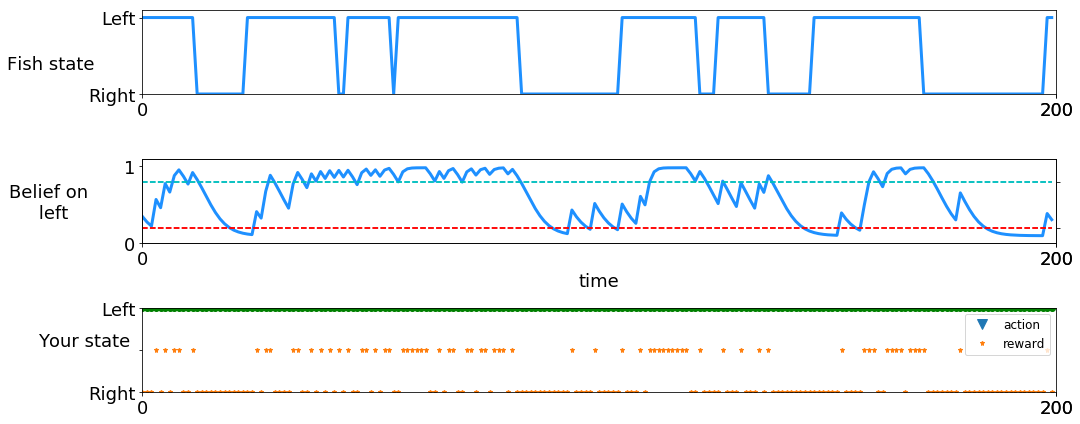

In [7]:
"""
Plot the dynamics of the binaryHMM task
"""
belief, loc, act, meas, world_state = binaryHMM_test.generateProcess()
binaryHMM_test.plot_dynamics(belief, loc, act, meas, world_state)

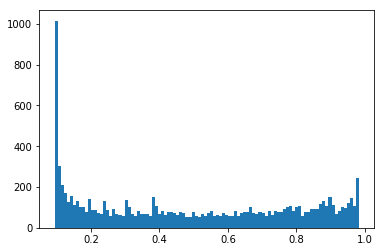

In [8]:
"""
Check the distribution of beliefs.
"""
binaryHMM_test.belief_histogram(belief[0, :]) # histgram of the belief on the left box

### Exercise 3: Value function 
Now we have generated behavioral for a parameterized policy. Let's calculate the value of that policy. 

Specifically, here the value is total expected utility per unit time.

$$V(\theta) = \frac{1}{T}\left(\sum_t U_s(s_t) + U_a(a_t)\right)$$ 

where $U_s(s_t)$ is the instataneous utility from the site, and $U_a(a_t)$ is the negative cost for switching.

**Suggestions**
* Fill in the function `value_function(meas, act, cost_sw)` given a sequence of measurements, actions, and the cost of switching. 

In [9]:
def value_function(meas, act, cost_sw):
    """
    value function 
    """
    act_int = (act == "switch" ).astype(int)       # convert labels to binary
    T = len(meas)   

    ###############################################################################
    ## Insert your code here to:
    ##        compute the value function
    ###############################################################################
    ###############################################################################
    # Solution to be removed
    value = (np.sum(meas) - np.sum(act_int) * cost_sw) / T     # rate of catching fish - costs
    ###############################################################################

    #value = ...     # rate of catching fish - costs

    return value

### Exercise 4: Utility function vs threshold 
Let's find the threshold that yields the highest total value. We have provided code for plotting value versus threshold. You can then find the threshold $\theta^*$ with the highest value, i.e. the policy that gives optimal control.

After that, change the other parameters and explore the resultant values. 




In [10]:
# Brute force search for optimal policy: what is the best threshold?
# This function is needed for the second exercise.

def value_threshold(params, cost_sw, step):
    threshold_array = np.arange(0, 1 + step, step)
    value_array = np.zeros(threshold_array.shape)
    
    T, p_stay, rp_high, rp_low, _ = params
    
    for i in range(len(threshold_array)):
        threshold = threshold_array[i]
        
        params = [T, p_stay, rp_high, rp_low, threshold]
        binaryHMM_test = binaryHMM(params)
        _, _, act, meas, _ = binaryHMM_test.generateProcess()
        
        value_array[i] = value_function(meas, act, cost_sw)
    
    return threshold_array, value_array

def plot_value_threshold(params, cost_sw, step = 0.05):
    threshold_array, value_array = value_threshold(params, cost_sw, step)

    fig_, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(threshold_array, value_array)
    ax.set_ylim([np.min(value_array), np.max(value_array)])
    ax.set_title('threshold vs value with switching cost c = %.2f'%cost_sw, fontsize = 20)
    ax.set_xlabel('threshold', fontsize = 16)
    ax.set_ylabel('value', fontsize = 16)
    plt.show()

In [11]:
# T = 10000
# p_stay = .95          # state transiton probability
# rp_high = .4
# rp_low = .1

cost_sw = 3

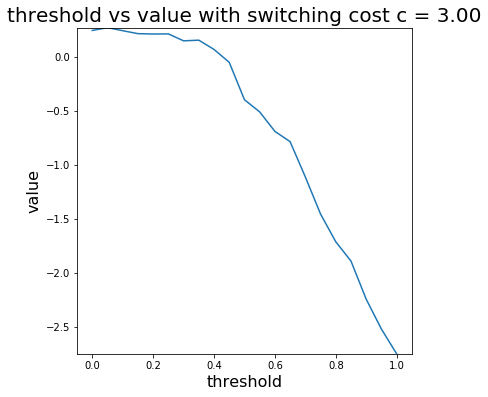

In [12]:
params = [T, p_stay, rp_high, rp_low, _]
plot_value_threshold(params, cost_sw)